<a href="https://colab.research.google.com/github/Developer-Abnam/100-Days-Of-ML-Code/blob/master/diseasepredictoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disease Prediction Using Machine Learning

**Step 1: Import Libraries**

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
%matplotlib inline

**Step 2: Reading the dataset**

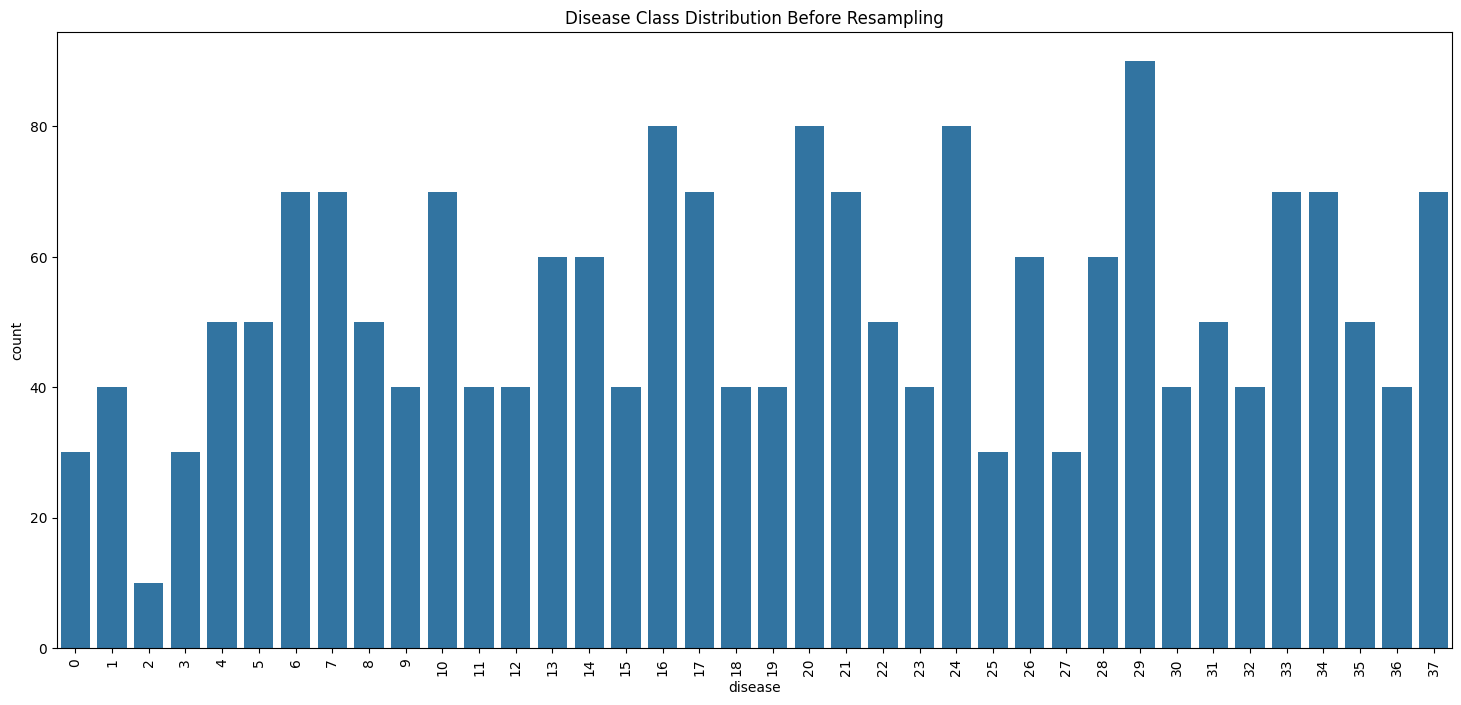

In [9]:
data = pd.read_csv('/content/improved_disease_dataset.csv')

encoder = LabelEncoder()
data['disease'] = encoder.fit_transform(data['disease'])

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

plt.figure(figsize=(18, 8))
sns.countplot(x=y)
plt.title("Disease Class Distribution Before Resampling")
plt.xticks(rotation=90)
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

**Step 3: Cross-Validation with Stratified K-Fold**

In [20]:
if 'gender' in X_resampled.columns:
  le = LabelEncoder()
  X_resampled['gender'] = le.fit_transform(X_resampled['gender'])
X_resampled = X_resampled.fillna(0)

if len(y_resampled.shape) > 1:
  y_resampled = y_resampled.values.ravel()

models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

cv_scoring = "accuracy"
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
  try:
    scores = cross_val_score(
      model,
      X_resampled,
      y_resampled,
      cv=stratified_kfold,
      scoring=cv_scoring,
      n_jobs=-1,
      error_score="raise"
  )

    print("="*50)
    print(f"Model: {model_name}")
    print(f"Scores: {scores}")
    print(f"Mean Accuracy: {scores.mean():.4f}")

  except Exception as e:
    print("=" * 50)
    print(f"Model: {model_name} failed with error:")
    print(e)

Model: Decision Tree
Scores: [0.5497076  0.54385965 0.5380117  0.53654971 0.52777778]
Mean Accuracy: 0.5392
Model: Random Forest
Scores: [0.55994152 0.55263158 0.5497076  0.54532164 0.53947368]
Mean Accuracy: 0.5494
Model: SVM
Scores: [0.51315789 0.51169591 0.49707602 0.48245614 0.49561404]
Mean Accuracy: 0.5000


**Step 4: Training Individual Models and Generating Confusion Matrices**

Support Vector Machine

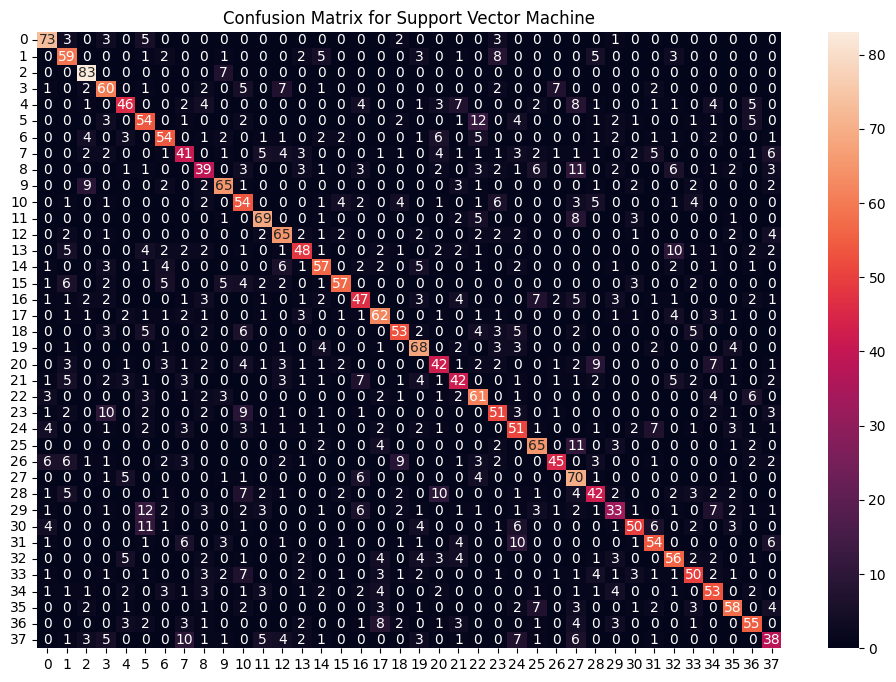

SVM Accuracy: 60.53%


In [28]:
svm_model = SVC()
svm_model.fit(X_resampled, y_resampled)
svm_preds = svm_model.predict(X_resampled)

confusion_matrix_svm = confusion_matrix(y_resampled, svm_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix_svm, annot=True, fmt="d")
plt.title("Confusion Matrix for Support Vector Machine")
plt.show()

print(f"SVM Accuracy: {accuracy_score(y_resampled, svm_preds) * 100:.2f}%")

**Naive Bayes Classifier**

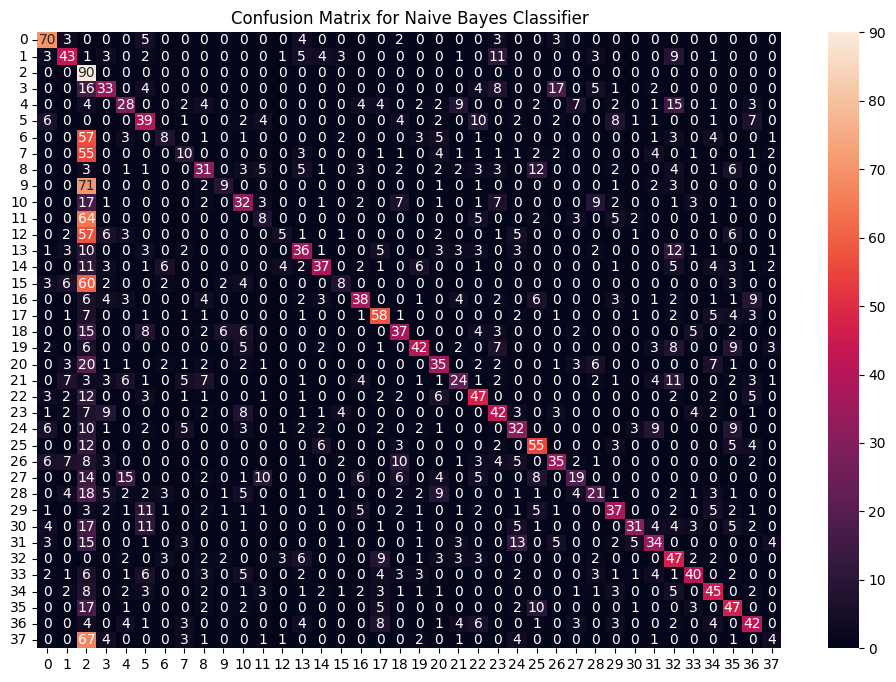

NVC Accuracy: 37.98%


In [29]:
nb_model = GaussianNB()
nb_model.fit(X_resampled, y_resampled)
nb_preds = nb_model.predict(X_resampled)

confusion_matrix_nb = confusion_matrix(y_resampled, nb_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix_nb, annot=True, fmt="d")
plt.title("Confusion Matrix for Naive Bayes Classifier")
plt.show()

print(f"NVC Accuracy: {accuracy_score(y_resampled, nb_preds) * 100:.2f}%")

**Random Forest Classifier**

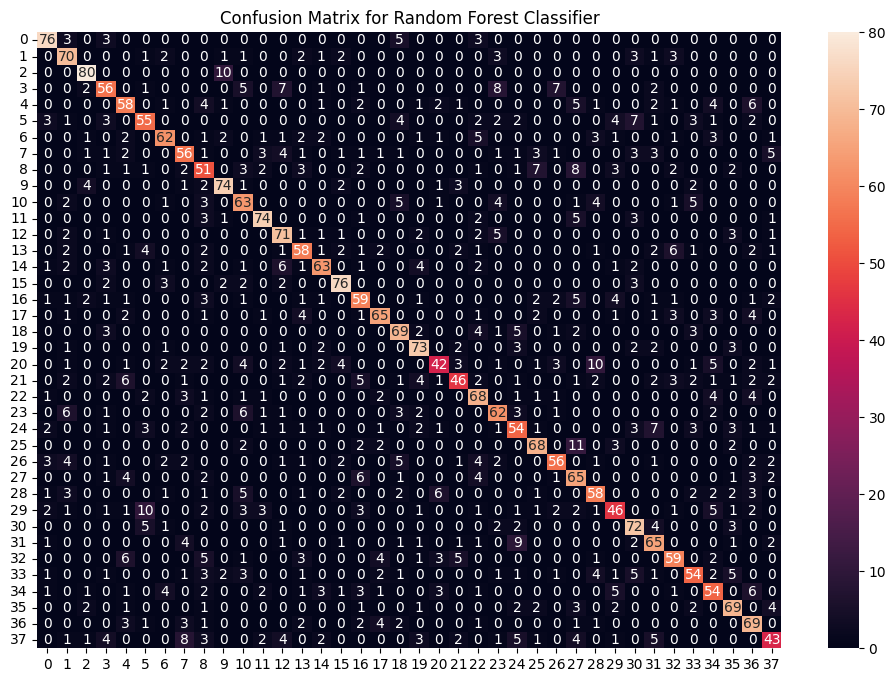

Random Forest Accuracy: 68.98%


In [30]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)
rf_preds = rf_model.predict(X_resampled)

cf_matrix_rf = confusion_matrix(y_resampled, rf_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_rf, annot=True, fmt="d")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

print(f"Random Forest Accuracy: {accuracy_score(y_resampled, rf_preds) * 100:.2f}%")

**Step 5: Combining Predictions for Robustness**

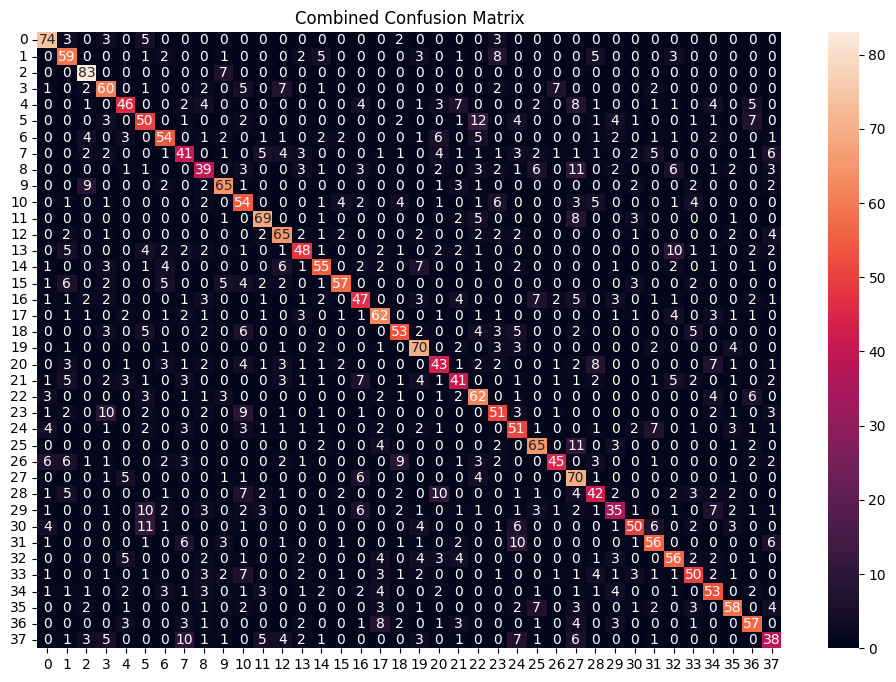

Combined Accuracy: 60.64%


In [34]:
from statistics import mode

final_preds = [mode([i,j,k]) for i,j,k in zip(svm_preds, nb_preds, rf_preds)]

combined_confusion_mx = confusion_matrix(y_resampled, final_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(combined_confusion_mx, annot=True, fmt="d")
plt.title("Combined Confusion Matrix")
plt.show()

print(f"Combined Accuracy: {accuracy_score(y_resampled, final_preds) * 100:.2f}%")

**Step 6: Creating Prediction Function**

In [43]:
symptoms = X.columns.values
symptom_index = {symptom: idx for idx, symptom in enumerate(symptoms)}
def predict_disease(input_symptoms):
  input_symptoms = input_symptoms.split(',')
  input_data = [0] * len(symptoms)
  for symptom in input_symptoms:
    if symptom in symptom_index:
      input_data[symptom_index[symptom]] = 1

  input_df = pd.DataFrame([input_data], columns=symptoms)

  rf_predicts = encoder.classes_[rf_model.predict(input_df)[0]]
  nb_predicts = encoder.classes_[nb_model.predict(input_df)[0]]
  svm_predicts = encoder.classes_[svm_model.predict(input_df)[0]]
  final_predicts = mode([rf_predicts, nb_predicts, svm_predicts])

  return {
      "Random Forest Prediction": rf_predicts,
      "Naive Bayes Prediction": nb_predicts,
      "SVM Prediction": svm_predicts,
      "Final Prediction": final_predicts
  }

print(predict_disease("skin_rash, fever, headache"))

{'Random Forest Prediction': 'Impetigo', 'Naive Bayes Prediction': 'Urinary tract infection', 'SVM Prediction': 'Impetigo', 'Final Prediction': 'Impetigo'}
